# Imports

We use the following libraries to fetch and parse html pages, and to interact with the Foursquare API.

In [1]:
from bs4 import BeautifulSoup
import requests
import requests_cache

# Request_cache caches all calls to wikipedia and foursquare so we only have to do it once.
requests_cache.install_cache('requests_cache')

We use regular expressions, e.g. to extract population count and city coordinates from scraped webpages

In [2]:
import re

We use Pandas for building the dataframe.

In [3]:
import pandas as pd

We use folium for creating maps

In [4]:
import folium
from folium import plugins

Matplotlib for graphs and color related functionality

In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

We use NumPy and Scikit-learn for clustering

In [83]:
import math
import numpy as np
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn import metrics

# Creating a Dutch Cities dataset

The wikipedia page [Tabel van Nederlandse gemeenten](https://nl.wikipedia.org/wiki/Tabel_van_Nederlandse_gemeenten) contains a table containing all municipalities in the Netherlands.
We are interested in this table as it  contains the actual cities, their population, some other statistics, and a link to their individual Wikipedia pages

## Scrape list of Dutch cities from Wikipedia

The following code fetches a wikipedia page

In [9]:
# location of the wikipedia article
url = "https://nl.wikipedia.org/wiki/Tabel_van_Nederlandse_gemeenten"

# fetch the article
response = requests.get(url)
article = response.text

We use BeautifulSoup to parse the obtained HTML, and find the first sortable table. This is the table of cities that dominates the Wikipedia article.

In [10]:
# parse with BeautifulSoup and find the first sortable table
soup = BeautifulSoup(article, 'html.parser')
table = soup.find('table', class_='sortable')

We create a new Pandas dataframe to hold our cities. We will also save its nation, its population count, area, population density, average income and its URL, as well as a URL to its city flag.

Some of the fields need to be integers or floats.

In [11]:
# create an empty DataFrame
cols=["City", "Province", "Population", "Area", "Density", "Income", "URL"]
df_cities = pd.DataFrame(columns=cols)
df_cities['Population'].astype(int)
df_cities['Area'].astype(float)
df_cities['Density'].astype(float)
df_cities['Income'].astype(int)

Series([], Name: Income, dtype: int32)

We can now traverse the entire table, scrape the needed information, and perform some cleanup where necessary.

In [12]:
# iterate trough all the rows in the table:
for tr in table.find_all('tr'):
    tds = tr.find_all('td')
    if not tds:
        continue                            # skips first row with headings

    citycell = tds[0].find_all('a')
    if (len(citycell)==2):
        url = "https://nl.wikipedia.org" + citycell[1]['href']
        city = citycell[1]['title'].replace('`','\'').replace('(gemeente)','').replace('(hoofdbetekenis)','').strip()
    else:
        url = "https://nl.wikipedia.org" + citycell[0]['href']
        city = citycell[0]['title'].replace('`','\'').replace('(gemeente)','').replace('(hoofdbetekenis)','').strip()
    
    try:
        province = tds[1].find_all('a')[1]['title'].replace('(hoofdbetekenis)','').replace('(provincie)','').replace('(Nederland)','').strip()
    except:
        province = "Geen"
        
    pop = int(re.compile(r'\[.*\]').sub("",tds[2].text).replace('(geschat)','').strip().replace('.','').replace('.',''))
    area = float(tds[3].text.strip().replace('.','').replace(',','.'))
    density = float(tds[4].text.strip().replace('.','').replace(',','.'))    
    try:    
        income = int(tds[5].text.strip().replace('.',''))   
    except ValueError:
        income = np.nan
        
    df_cities = df_cities.append({
        'City': str(city), 
        'Province': str(province), 
        'Population': pop,
        'Area': area,
        'Density': density,
        'Income': income,
        'URL': str(url),
    }, ignore_index=True)

Let's see the result:

In [13]:
print ("Shape: {}".format(df_cities.shape))
print ("There are {} unique city names".format(df_cities['City'].nunique()))
df_cities.head()

Shape: (383, 8)
There are 383 unique city names


,City,Province,Population,Area,Density,Income,URL,FlagURL
0,Aa en Hunze,Drenthe,25319,276.35,91.2,13400,https://nl.wikipedia.org/wiki/Aa_en_Hunze,NaN
1,Aalburg,Noord-Brabant,13191,50.40,257.5,12500,https://nl.wikipedia.org/wiki/Aalburg,NaN
2,Aalsmeer,Noord-Holland,31584,20.58,1512.7,14700,https://nl.wikipedia.org/wiki/Aalsmeer,NaN
3,Aalten,Gelderland,26943,96.57,278.7,11900,https://nl.wikipedia.org/wiki/Aalten_(gemeente),NaN
4,Achtkarspelen,Friesland,27897,102.61,272.7,11400,https://nl.wikipedia.org/wiki/Achtkarspelen,NaN


## Scrape individual city geographic coordinates

We now want the geographic coordinates for every city in the dataframe. These are located on the individual city pages on wikipedia. We already have those URL's.

We create a small function that scrapes the city webpage and uses a regular expression to scrape the coordinates. We then run this function for every row in the dataframe.

In [14]:
# Scrape an individual cities page for its coordinates
def scrape_city_coords(url):
    article = requests.get(url).text
    reg = re.search(r'"lat":(.*?),"lon":(.*?)}', article)
    if reg is None:
        return np.nan, np.nan
    lat = float(reg.group(1))
    lon = float(reg.group(2))
    return lat,lon

In [15]:
df_cities["Latitude"], df_cities["Longitude"] = zip(*df_cities["URL"].map(scrape_city_coords))
print("All done.")
print ("Shape: {}".format(df_cities.shape))

All done.
Shape: (383, 10)


## Fixing missing values

Let's see if there are any missing values (NaN).

In [16]:
df_cities[pd.isnull(df_cities).any(axis=1)]

,City,Province,Population,Area,Density,Income,URL,FlagURL,Latitude,Longitude
0,Aa en Hunze,Drenthe,25319,276.35,91.2,13400,https://nl.wikipedia.org/wiki/Aa_en_Hunze,NaN,53.000000,6.750000
1,Aalburg,Noord-Brabant,13191,50.40,257.5,12500,https://nl.wikipedia.org/wiki/Aalburg,NaN,51.752500,5.131944
2,Aalsmeer,Noord-Holland,31584,20.58,1512.7,14700,https://nl.wikipedia.org/wiki/Aalsmeer,NaN,52.263889,4.762500
3,Aalten,Gelderland,26943,96.57,278.7,11900,https://nl.wikipedia.org/wiki/Aalten_(gemeente),NaN,51.925000,6.580833
4,Achtkarspelen,Friesland,27897,102.61,272.7,11400,https://nl.wikipedia.org/wiki/Achtkarspelen,NaN,53.216667,6.133333
5,Alblasserdam,Zuid-Holland,20029,8.78,2261.6,12300,https://nl.wikipedia.org/wiki/Alblasserdam,NaN,51.865833,4.660833
6,Albrandswaard,Zuid-Holland,25259,22.18,1128.6,15100,https://nl.wikipedia.org/wiki/Albrandswaard,NaN,51.856667,4.403889
7,Alkmaar,Noord-Holland,108596,81.42,1316.3,13300,https://nl.wikipedia.org/wiki/Alkmaar_(gemeente),NaN,52.616667,4.766667
8,Almelo,Overijssel,72816,67.43,1072.2,11900,https://nl.wikipedia.org/wiki/Almelo,NaN,52.366667,6.666667
9,Almere,Flevoland,205220,130.47,1512.4,12500,https://nl.wikipedia.org/wiki/Almere,NaN,52.371667,5.220833


 It turns out some Incomes are missing (no problem) and some coordinates are missing. We can manually add those coordinates.

In [17]:
df_cities.at[114, "Latitude"], df_cities.at[114, "Longitude"] = 52.266667, 5.166667  # Gooise Meren
df_cities.at[204, "Latitude"], df_cities.at[204, "Longitude"] = 51.583333, 5.483333  # Meierijstad
df_cities.at[209, "Latitude"], df_cities.at[209, "Longitude"] = 53.184722, 6.811111  # Midden-Groningen
df_cities.at[223, "Latitude"], df_cities.at[223, "Longitude"] = 51.833333, 4.3       # Nissewaard
df_cities.at[338, "Latitude"], df_cities.at[338, "Longitude"] = 53.1875, 5.54        # Waadhoeke
df_cities.at[352, "Latitude"], df_cities.at[352, "Longitude"] = 53.091904, 7.126865  # Westerwolde

df_cities[pd.isnull(df_cities).any(axis=1)]

,City,Province,Population,Area,Density,Income,URL,FlagURL,Latitude,Longitude
0,Aa en Hunze,Drenthe,25319,276.35,91.2,13400,https://nl.wikipedia.org/wiki/Aa_en_Hunze,NaN,53.000000,6.750000
1,Aalburg,Noord-Brabant,13191,50.40,257.5,12500,https://nl.wikipedia.org/wiki/Aalburg,NaN,51.752500,5.131944
2,Aalsmeer,Noord-Holland,31584,20.58,1512.7,14700,https://nl.wikipedia.org/wiki/Aalsmeer,NaN,52.263889,4.762500
3,Aalten,Gelderland,26943,96.57,278.7,11900,https://nl.wikipedia.org/wiki/Aalten_(gemeente),NaN,51.925000,6.580833
4,Achtkarspelen,Friesland,27897,102.61,272.7,11400,https://nl.wikipedia.org/wiki/Achtkarspelen,NaN,53.216667,6.133333
5,Alblasserdam,Zuid-Holland,20029,8.78,2261.6,12300,https://nl.wikipedia.org/wiki/Alblasserdam,NaN,51.865833,4.660833
6,Albrandswaard,Zuid-Holland,25259,22.18,1128.6,15100,https://nl.wikipedia.org/wiki/Albrandswaard,NaN,51.856667,4.403889
7,Alkmaar,Noord-Holland,108596,81.42,1316.3,13300,https://nl.wikipedia.org/wiki/Alkmaar_(gemeente),NaN,52.616667,4.766667
8,Almelo,Overijssel,72816,67.43,1072.2,11900,https://nl.wikipedia.org/wiki/Almelo,NaN,52.366667,6.666667
9,Almere,Flevoland,205220,130.47,1512.4,12500,https://nl.wikipedia.org/wiki/Almere,NaN,52.371667,5.220833


## Getting venue information from Foursquare

In this section we will ask Foursquare for the Top Picks venues in every city in the Netherlands.

The following information is needed to connect with Foursquare API

In [18]:
CLIENT_ID = 'YPBVFDUZOP1M24BKCWGXIYZ3RFACOE3V35WSFY4DSCMRU44L' # your Foursquare ID
CLIENT_SECRET = 'VYHYTBSRIZBPYAOCP5ZEFV3YM4C40YEQCQWCUO4NC1JTPNJM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

We will ask Foursquare for the top picks in every city, then store its name, location and main category.

The following function takes series of Cities and their latituted and longitudes. It will then output a dataframe containing all these venues. 

We found that especially for bigger cities, Foursquare would give results only for the inner city. This can be corrected by adding a radius parameter, i.e. we will look in a certain radius.

But how big should that radius be? We are going to estimate it based on the area of the city. We assume the city is a perfect circle, with area $A=\pi r^2$. That means we can estimate the radius in which to search as $r = \sqrt{A/\pi}$

In [19]:
def getRecommendedVenues(cities, latitudes, longitudes, areas):
    
    venues_list=[]
    for city, lat, lon, area in zip(cities, latitudes, longitudes, areas):
            
        radius = 1000 * round(math.sqrt(area / math.pi), 2)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&section=topPicks&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lon,
            radius,
            100)
            
        # make the GET request
        response = requests.get(url)
        if response.status_code == requests.codes.ok:
            results = response.json()["response"]['groups'][0]['items']
        else:
            print ("status was:" + str(response.status_code))
            print ("could not scrape " + url)
            break
               
        # return only relevant information for each nearby venue
        venues_list.append([(
            city,
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City',
                  'Venue',
                  'Venue ID',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now we can run it on all the cities from our cities dataframe and store the found venues in a new dataframe.
This can take a while when running for the first time, and also fail a few times with a 504 error. But every 

In [20]:
df_venues = getRecommendedVenues(df_cities['City'], df_cities['Latitude'], df_cities['Longitude'], df_cities['Area'])
print ("Found {} venues for {} different cities".format(df_venues.shape[0], len(df_venues.groupby('City'))))
df_venues.head()

Found 10219 venues for 383 different cities


,City,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,Aa en Hunze,Grand Café Saksen,4b09258ff964a5206b1423e3,52.965733,6.675630,Café
1,Aa en Hunze,Jumbo,4dfc81bb227185f38b94f008,53.002128,6.764441,Supermarket
2,Aa en Hunze,Herberg De Fazant,4d612b61b19fa14398cdfec8,53.049120,6.638503,Restaurant
3,Aa en Hunze,IJssalon La Dolce,4d97223b97d06ea8cf61130b,52.925692,6.789947,Ice Cream Shop
4,Aa en Hunze,Zwembad | Hof van Saksen,4c3b2cb3d94dc9b63156ffe7,52.965237,6.676055,Pool


## Saving the dataframes

We export the dataframes so we don't have to scrape again.  
First as CSV, as this is a very generic format.  
Secondly as pickle, since this is a quick way to import the dataframe again.

In [21]:
# export both dataframes as CSV
df_cities.to_csv('cities.csv')
df_venues.to_csv('venues.csv')

In [22]:
# export both dataframe as pickles
df_cities.to_pickle('cities.pickle')
df_venues.to_pickle('venues.pickle')

# Showing cities and venues on a map

## Import dataframes from previous Section.

To avoid having to scrape all data again, we read the dataframes pickled in the previous section.

In [23]:
df_cities = pd.read_pickle('cities.pickle')
df_cities.head()

,City,Province,Population,Area,Density,Income,URL,FlagURL,Latitude,Longitude
0,Aa en Hunze,Drenthe,25319,276.35,91.2,13400,https://nl.wikipedia.org/wiki/Aa_en_Hunze,NaN,53.000000,6.750000
1,Aalburg,Noord-Brabant,13191,50.40,257.5,12500,https://nl.wikipedia.org/wiki/Aalburg,NaN,51.752500,5.131944
2,Aalsmeer,Noord-Holland,31584,20.58,1512.7,14700,https://nl.wikipedia.org/wiki/Aalsmeer,NaN,52.263889,4.762500
3,Aalten,Gelderland,26943,96.57,278.7,11900,https://nl.wikipedia.org/wiki/Aalten_(gemeente),NaN,51.925000,6.580833
4,Achtkarspelen,Friesland,27897,102.61,272.7,11400,https://nl.wikipedia.org/wiki/Achtkarspelen,NaN,53.216667,6.133333


In [24]:
df_venues = pd.read_pickle('venues.pickle')
df_venues.head()

,City,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,Aa en Hunze,Grand Café Saksen,4b09258ff964a5206b1423e3,52.965733,6.675630,Café
1,Aa en Hunze,Jumbo,4dfc81bb227185f38b94f008,53.002128,6.764441,Supermarket
2,Aa en Hunze,Herberg De Fazant,4d612b61b19fa14398cdfec8,53.049120,6.638503,Restaurant
3,Aa en Hunze,IJssalon La Dolce,4d97223b97d06ea8cf61130b,52.925692,6.789947,Ice Cream Shop
4,Aa en Hunze,Zwembad | Hof van Saksen,4c3b2cb3d94dc9b63156ffe7,52.965237,6.676055,Pool


## Putting cities on the map

In [25]:
# create map of the world using latitude and longitude values
cities_map = folium.Map(location=[51.666666666667,5],zoom_start=3)

# create a full screen button
fs = plugins.Fullscreen()
cities_map.add_child(fs)

# allow the city markers to cluster
cities_cluster = plugins.MarkerCluster().add_to(cities_map)

# add markers to map for every city
for lat, lng, city, in zip(df_cities['Latitude'], df_cities['Longitude'], df_cities['City']):
    label = "{}, ({},{})".format(city,lat,lng)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
    ).add_to(cities_cluster)  
    
# save the map to interactive html, then display
cities_map.save('cities_map.html')
cities_map

Here we can clearly see the three municipalities in the Caribbean Netherlands. 

## Putting venues on a map

We cannot put all venues on the map as there are too many, and this goes beyond Folium capacity.

However, we can demonstrate the idea by restricting to the venues of a single city. In this case: Eindhoven

In [26]:
df_venues_ehv = df_venues.loc[df_venues['City'] == "Eindhoven"]

In [248]:
# create map of the world using latitude and longitude values
ehv_map = folium.Map(location=[51.433333, 5.483333],zoom_start=13, prefer_canvas=True )

# create a full screen button
fs = plugins.Fullscreen()
ehv_map.add_child(fs)

# allow the city markers to cluster
ehv_cluster = plugins.MarkerCluster().add_to(ehv_map)

# add markers to map for every venue
for lat, lng, venue, cat in zip(df_venues_ehv['Venue Latitude'], df_venues_ehv['Venue Longitude'], df_venues_ehv['Venue'],  df_venues_ehv['Venue Category']):
    label = '{}: {}'.format(venue, cat)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
    ).add_to(ehv_cluster)  
    
# save the map to interactive html, then display
ehv_map.save('ehv_map.html')
ehv_map

# Clustering cities

## Import dataframes

To avoid having to scrape all data again, we read the dataframes pickled in the previous section.

In [28]:
df_cities = pd.read_pickle('cities.pickle')
df_cities.head()

,City,Province,Population,Area,Density,Income,URL,FlagURL,Latitude,Longitude
0,Aa en Hunze,Drenthe,25319,276.35,91.2,13400,https://nl.wikipedia.org/wiki/Aa_en_Hunze,NaN,53.000000,6.750000
1,Aalburg,Noord-Brabant,13191,50.40,257.5,12500,https://nl.wikipedia.org/wiki/Aalburg,NaN,51.752500,5.131944
2,Aalsmeer,Noord-Holland,31584,20.58,1512.7,14700,https://nl.wikipedia.org/wiki/Aalsmeer,NaN,52.263889,4.762500
3,Aalten,Gelderland,26943,96.57,278.7,11900,https://nl.wikipedia.org/wiki/Aalten_(gemeente),NaN,51.925000,6.580833
4,Achtkarspelen,Friesland,27897,102.61,272.7,11400,https://nl.wikipedia.org/wiki/Achtkarspelen,NaN,53.216667,6.133333


In [29]:
df_venues = pd.read_pickle('venues.pickle')
df_venues.head()

,City,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,Aa en Hunze,Grand Café Saksen,4b09258ff964a5206b1423e3,52.965733,6.675630,Café
1,Aa en Hunze,Jumbo,4dfc81bb227185f38b94f008,53.002128,6.764441,Supermarket
2,Aa en Hunze,Herberg De Fazant,4d612b61b19fa14398cdfec8,53.049120,6.638503,Restaurant
3,Aa en Hunze,IJssalon La Dolce,4d97223b97d06ea8cf61130b,52.925692,6.789947,Ice Cream Shop
4,Aa en Hunze,Zwembad | Hof van Saksen,4c3b2cb3d94dc9b63156ffe7,52.965237,6.676055,Pool


## Counting venue categories

Just as in the lectures, we want to find out what the most recommended types of venues are for each city.

We do this by first turning the venue categories in one-hot notations, and then averaging these numbers for every city.
This automatically takes care of having different amounts of venues for different cities.

In [30]:
# one hot encoding of venue category
df_venues_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add city and nation columns back to the dataframe
df_venues_onehot['City'] = df_venues['City']

# move those column to the first column
fixed_columns = list(df_venues_onehot.columns[-1:]) + list(df_venues_onehot.columns[:-1])
df_venues_onehot = df_venues_onehot[fixed_columns]

df_venues_onehot.head()

,City,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,Apres Ski Bar,...,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Warehouse Store,Windmill,Wine Bar,Wine Shop,Women's Store,Zoo Exhibit
0,Aa en Hunze,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Aa en Hunze,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aa en Hunze,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Aa en Hunze,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Aa en Hunze,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Most common venue categories per city

In [31]:
df_venues_grouped = df_venues_onehot.groupby(['City']).sum().reset_index()

In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
num_top_venues = 5

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    columns.append('Common Venue {}'.format(ind+1))

# create a new dataframe
df_common_venues = pd.DataFrame(columns=columns)
df_common_venues['City'] = df_venues_grouped['City']

# actually perform counting
for ind in np.arange(df_venues_grouped.shape[0]):
    df_common_venues.iloc[ind, 1:] = return_most_common_venues(df_venues_grouped.iloc[ind, :], num_top_venues)

In [34]:
df_common_venues.head()

,City,Common Venue 1,Common Venue 2,Common Venue 3,Common Venue 4,Common Venue 5
0,'s-Hertogenbosch,Supermarket,Café,Restaurant,Coffee Shop,Bar
1,Aa en Hunze,Resort,Restaurant,Park,Supermarket,Pool
2,Aalburg,Restaurant,Grocery Store,Harbor / Marina,Supermarket,History Museum
3,Aalsmeer,Harbor / Marina,French Restaurant,Snack Place,Bar,Restaurant
4,Aalten,Bar,German Restaurant,Diner,Supermarket,Pet Store


## Finding similar cities

For clustering, we use the averages for every category as found in section 3, but drop the city attributes

In [207]:
df_clustering = df_venues_onehot.groupby(['City']).nth(list(range(10)), dropna=None).groupby(['City']).max().reset_index().drop(['City'],1).astype(bool)
df_clustering.head()

,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,Apres Ski Bar,Argentinian Restaurant,...,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Warehouse Store,Windmill,Wine Bar,Wine Shop,Women's Store,Zoo Exhibit
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Finding optimal value for $k$

We look at a silhouette score for various values of k to find an optimal one.

A first look immediately finds that 2,3,4 give better values, but I find that too few clusters.

maximum is 0.028156803540930964, which occurs at k=9


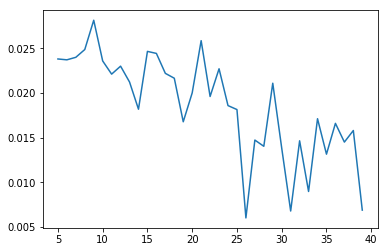

In [208]:
START = 5
END = 40
scores = []
for k in range(START, END):
    # run k-means clustering
    kmeans = KMeans(n_clusters=k).fit(df_clustering)
    
    scores.append(metrics.silhouette_score(df_clustering, kmeans.labels_))   
print( "maximum is {}, which occurs at k={}".format(np.max(scores),np.argmax(scores)+START))
kclusters=np.argmax(scores)+START
plt.plot(range(START,END),scores)

We choose to go for $k=7$, which gives an initial peak while still providing a useful amount of clusters.

### Clustering

We use Scikit-learn for kmeans clustering, with $k=\mathrm{kclusters}$ clusters.

In [209]:
kmeans = KMeans(n_clusters=kclusters).fit(df_clustering)

We add these labels to the cities dataframe, as well as the most common venues found in the previous section.

We save the result as a new dataframe cities2

In [210]:
df_common_venues['Cluster label'] = kmeans.labels_

df_cities2 = pd.merge(df_common_venues, df_cities, how='left',
        on=['City'], validate="1:1")
df_cities2.head()

,City,Common Venue 1,Common Venue 2,Common Venue 3,Common Venue 4,Common Venue 5,Cluster label,Province,Population,Area,Density,Income,URL,FlagURL,Latitude,Longitude
0,'s-Hertogenbosch,Supermarket,Café,Restaurant,Coffee Shop,Bar,6,Noord-Brabant,153434,84.63,1783.7,13900,https://nl.wikipedia.org/wiki/%27s-Hertogenbos...,NaN,51.689167,5.303056
1,Aa en Hunze,Resort,Restaurant,Park,Supermarket,Pool,8,Drenthe,25319,276.35,91.2,13400,https://nl.wikipedia.org/wiki/Aa_en_Hunze,NaN,53.000000,6.750000
2,Aalburg,Restaurant,Grocery Store,Harbor / Marina,Supermarket,History Museum,4,Noord-Brabant,13191,50.40,257.5,12500,https://nl.wikipedia.org/wiki/Aalburg,NaN,51.752500,5.131944
3,Aalsmeer,Harbor / Marina,French Restaurant,Snack Place,Bar,Restaurant,4,Noord-Holland,31584,20.58,1512.7,14700,https://nl.wikipedia.org/wiki/Aalsmeer,NaN,52.263889,4.762500
4,Aalten,Bar,German Restaurant,Diner,Supermarket,Pet Store,4,Gelderland,26943,96.57,278.7,11900,https://nl.wikipedia.org/wiki/Aalten_(gemeente),NaN,51.925000,6.580833


## Saving the dataframes

Again, we save the intermediate result to avoid having to rerun these commands

In [211]:
df_cities2.to_csv('cities2.csv')
df_cities2.to_pickle('cities2.pickle')

# Showing clusters on a map

In this section we use the clusters identified in the previous section and combine the whole into a pretty package.

## Import dataframes

To avoid having to rerun all commands again, we read the dataframes pickled in the previous section.

In [212]:
df_cities2 = pd.read_pickle('cities2.pickle')
df_cities2.head()

,City,Common Venue 1,Common Venue 2,Common Venue 3,Common Venue 4,Common Venue 5,Cluster label,Province,Population,Area,Density,Income,URL,FlagURL,Latitude,Longitude
0,'s-Hertogenbosch,Supermarket,Café,Restaurant,Coffee Shop,Bar,6,Noord-Brabant,153434,84.63,1783.7,13900,https://nl.wikipedia.org/wiki/%27s-Hertogenbos...,NaN,51.689167,5.303056
1,Aa en Hunze,Resort,Restaurant,Park,Supermarket,Pool,8,Drenthe,25319,276.35,91.2,13400,https://nl.wikipedia.org/wiki/Aa_en_Hunze,NaN,53.000000,6.750000
2,Aalburg,Restaurant,Grocery Store,Harbor / Marina,Supermarket,History Museum,4,Noord-Brabant,13191,50.40,257.5,12500,https://nl.wikipedia.org/wiki/Aalburg,NaN,51.752500,5.131944
3,Aalsmeer,Harbor / Marina,French Restaurant,Snack Place,Bar,Restaurant,4,Noord-Holland,31584,20.58,1512.7,14700,https://nl.wikipedia.org/wiki/Aalsmeer,NaN,52.263889,4.762500
4,Aalten,Bar,German Restaurant,Diner,Supermarket,Pet Store,4,Gelderland,26943,96.57,278.7,11900,https://nl.wikipedia.org/wiki/Aalten_(gemeente),NaN,51.925000,6.580833


## Putting the clusters on a map

How many cluster labels did we create?

In [213]:
kclusters = df_cities2['Cluster label'].nunique()
print ("We have {} different clusters of cities".format(kclusters))

We have 9 different clusters of cities


Create a color table for these clusters

In [214]:
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

Now actually put the cities on the map with a color depending on their cluster.

In [215]:
# create map of the world using latitude and longitude values
cluster_map = folium.Map(location=[51.666666666667,5],zoom_start=7)

# create a full screen button
fs = plugins.Fullscreen()
cluster_map.add_child(fs)


# add markers to map for every city
for lat, lng, city, cluster in zip(df_cities2['Latitude'], df_cities2['Longitude'], df_cities2['City'], df_cities2['Cluster label']):
    label = "{}, ({},{})".format(city,lat,lng)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color='#3186cc',
    ).add_to(cluster_map)  
    
# save the map to interactive html, then display
cluster_map.save('cluster_map.html')
cluster_map

## Adding more information to the map

Let's see if we can add some useful information to each of the cities.

I want to create a popup along the following lines:

**City**
population xxxx
Coordinates
link to wikipedia page

**Top 10 venue types in this city**
- category 1
- category 2

**top 10 venues in this city**
- venue 1
- venue 2

**Similar cities**
all cities with same cluster label

### Find similar cities

The following code make a list of string for each city within a given cluster.
Then it joins this list into the cities dataframe

In [216]:
def make_city_list(cities):
    citylist = []
    for city, nation in zip(cities, nations):
         citylist.append("{} ({})".format(city, nation))
    return citylist

In [217]:
clusters = pd.DataFrame(df_cities2.groupby('Cluster label').apply(lambda x: ", ".join(x['City'].tolist())), columns=['Similar'])
clusters

,Similar
Cluster label,
0,"Almelo, Alphen aan den Rijn, Apeldoorn, Bergen..."
1,"Almere, Amstelveen, Capelle aan den IJssel, Ge..."
2,"Alblasserdam, Appingedam, Beek, Bodegraven-Ree..."
3,"Asten, Bedum, Beemster, Beesel, Bergen (Limbur..."
4,"Aalburg, Aalsmeer, Aalten, Achtkarspelen, Amst..."
5,"Borsele, Bunschoten, Dalfsen, De Ronde Venen, ..."
6,"'s-Hertogenbosch, Alkmaar, Amersfoort, Arnhem,..."
7,"Albrandswaard, Alphen-Chaam, Ameland, Berg en ..."
8,"Aa en Hunze, Baarle-Nassau, Barendrecht, Barne..."


In [218]:
df_cities3 = pd.merge(df_cities2, clusters, on=['Cluster label'])

### Find top 5 venues

For this we need to re-import the venues table from notebook 1.

Foursquare already returned results in order of recommendation, so we just take the first ten of every city.

We create a list of those top 10 and merge it into the cities dataframe

In [219]:
df_venues = pd.read_pickle('venues.pickle')
df_top_venues = df_venues.groupby(['City'], as_index=False).nth(list(range(5)), dropna=None)

In [220]:
def create_venue_tuple(x):
    lst = []
    for v,c,i in  zip(x['Venue'], x['Venue Category'],  x['Venue ID']):
        lst.append({"Venue": v, "Category": c, "Id": i})
    return lst

In [221]:
venues = pd.DataFrame(df_top_venues.groupby(['City'], as_index=True).apply(create_venue_tuple), columns=['Top Venues'])
venues.head()

,Top Venues
City,
's-Hertogenbosch,"[{'Venue': 'Banketbakkerij Jan de Groot', 'Cat..."
Aa en Hunze,"[{'Venue': 'Grand Café Saksen', 'Category': 'C..."
Aalburg,"[{'Venue': 'Café Havenzicht', 'Category': 'Bar..."
Aalsmeer,"[{'Venue': 'Chimpie Champ', 'Category': 'Playg..."
Aalten,"[{'Venue': 'Vakantiepark De Twee Bruggen', 'Ca..."


In [222]:
df_cities3 = pd.merge(df_cities3, venues, on=['City'])

### Clean up most common categories

We would also like to have the most common categories in a list form, instead of separate columns

In [223]:
df_cities3['Categories']  = df_cities3[df_cities3.columns[1:6]].values.tolist()
df_cities3 = df_cities3.drop(df_cities3.columns[1:6], axis=1)

In [224]:
df_cities3.head()

,City,Cluster label,Province,Population,Area,Density,Income,URL,FlagURL,Latitude,Longitude,Similar,Top Venues,Categories
0,'s-Hertogenbosch,6,Noord-Brabant,153434,84.63,1783.7,13900,https://nl.wikipedia.org/wiki/%27s-Hertogenbos...,NaN,51.689167,5.303056,"'s-Hertogenbosch, Alkmaar, Amersfoort, Arnhem,...","[{'Venue': 'Banketbakkerij Jan de Groot', 'Cat...","[Supermarket, Café, Restaurant, Coffee Shop, Bar]"
1,Alkmaar,6,Noord-Holland,108596,81.42,1316.3,13300,https://nl.wikipedia.org/wiki/Alkmaar_(gemeente),NaN,52.616667,4.766667,"'s-Hertogenbosch, Alkmaar, Amersfoort, Arnhem,...","[{'Venue': 'Anne & Max', 'Category': 'Coffee S...","[Coffee Shop, Restaurant, Fast Food Restaurant..."
2,Amersfoort,6,Utrecht,155614,62.88,2429.3,13900,https://nl.wikipedia.org/wiki/Amersfoort_(hoof...,NaN,52.156389,5.389722,"'s-Hertogenbosch, Alkmaar, Amersfoort, Arnhem,...","[{'Venue': 'Vlaams Friteshuis van Gogh', 'Cate...","[Restaurant, Furniture / Home Store, Plaza, Ho..."
3,Arnhem,6,Gelderland,157660,98.25,1552.2,12800,https://nl.wikipedia.org/wiki/Arnhem,NaN,51.983333,5.916667,"'s-Hertogenbosch, Alkmaar, Amersfoort, Arnhem,...","[{'Venue': 'Nederlands Openluchtmuseum', 'Cate...","[Coffee Shop, Restaurant, Café, Park, Supermar..."
4,Assen,6,Drenthe,67776,82.09,817.8,12600,https://nl.wikipedia.org/wiki/Assen,NaN,52.993611,6.559722,"'s-Hertogenbosch, Alkmaar, Amersfoort, Arnhem,...","[{'Venue': 'Coffee & Tasty', 'Category': 'Coff...","[Hotel, Shopping Mall, Ice Cream Shop, Superma..."


### Create HTML description for each city

In [225]:
def create_label(x):
    html = "<h1>{}</h1>\n".format(x['City'])
    html += "<p>Latitude: {},<br/> Longitude: {}</p>\n".format(x['Latitude'], x['Longitude'])
    html += "<p><a href=\"{}\">Wikipedia link</a></p>\n".format(x['URL'])
    html += "<p>Most common venue categories:</p>\n<ol>\n"
    for a in x['Categories']:
        html += "<li>{}</li>\n".format(a)
    html += "</ol>\n"
    
    html += "<p>Most popular venues:</p>\n<ol>\n"
    for a in x['Top Venues']:
        html += "<li><a href=\"https://foursquare.com/v/{}\">{}</a> - {}</li>\n".format(a['Id'], a['Venue'].replace('`','\''), a['Category'])
    html += "</ol>\n"
    
    html += "<p>Similar cities [cluster {}]: ".format(x['Cluster label'])
    html += x['Similar']
    html += "</p>\n"
    
    return html

In [226]:
df_cities3['label'] = df_cities3.apply(create_label, axis=1)

In [227]:
df_cities3.head()

,City,Cluster label,Province,Population,Area,Density,Income,URL,FlagURL,Latitude,Longitude,Similar,Top Venues,Categories,label
0,'s-Hertogenbosch,6,Noord-Brabant,153434,84.63,1783.7,13900,https://nl.wikipedia.org/wiki/%27s-Hertogenbos...,NaN,51.689167,5.303056,"'s-Hertogenbosch, Alkmaar, Amersfoort, Arnhem,...","[{'Venue': 'Banketbakkerij Jan de Groot', 'Cat...","[Supermarket, Café, Restaurant, Coffee Shop, Bar]",<h1>'s-Hertogenbosch</h1>\n<p>Latitude: 51.689...
1,Alkmaar,6,Noord-Holland,108596,81.42,1316.3,13300,https://nl.wikipedia.org/wiki/Alkmaar_(gemeente),NaN,52.616667,4.766667,"'s-Hertogenbosch, Alkmaar, Amersfoort, Arnhem,...","[{'Venue': 'Anne & Max', 'Category': 'Coffee S...","[Coffee Shop, Restaurant, Fast Food Restaurant...",<h1>Alkmaar</h1>\n<p>Latitude: 52.616666666667...
2,Amersfoort,6,Utrecht,155614,62.88,2429.3,13900,https://nl.wikipedia.org/wiki/Amersfoort_(hoof...,NaN,52.156389,5.389722,"'s-Hertogenbosch, Alkmaar, Amersfoort, Arnhem,...","[{'Venue': 'Vlaams Friteshuis van Gogh', 'Cate...","[Restaurant, Furniture / Home Store, Plaza, Ho...",<h1>Amersfoort</h1>\n<p>Latitude: 52.156388888...
3,Arnhem,6,Gelderland,157660,98.25,1552.2,12800,https://nl.wikipedia.org/wiki/Arnhem,NaN,51.983333,5.916667,"'s-Hertogenbosch, Alkmaar, Amersfoort, Arnhem,...","[{'Venue': 'Nederlands Openluchtmuseum', 'Cate...","[Coffee Shop, Restaurant, Café, Park, Supermar...","<h1>Arnhem</h1>\n<p>Latitude: 51.983333333333,..."
4,Assen,6,Drenthe,67776,82.09,817.8,12600,https://nl.wikipedia.org/wiki/Assen,NaN,52.993611,6.559722,"'s-Hertogenbosch, Alkmaar, Amersfoort, Arnhem,...","[{'Venue': 'Coffee & Tasty', 'Category': 'Coff...","[Hotel, Shopping Mall, Ice Cream Shop, Superma...","<h1>Assen</h1>\n<p>Latitude: 52.993611111111,<..."


### Create circle size based on area

We want the circles on the map to have a radius in such a way that the whole circle has an area equal to the one in the table

In [228]:
def radius(area):
    return 1000 * round(math.sqrt(area / math.pi), 2)

#### Create circle opacity based on population count

We want the circles on the map to have a opacity of MINOPC for the city with the smallest population, and MAXOPC for the city with the largest population.

In [229]:
MINOPC = 0.2
MAXOPC = 1.0
popmin = min(df_cities3['Population'])
popmax = max(df_cities3['Population'])

def pop_opc(pop):
    return MINOPC + (MAXOPC - MINOPC)*(pop - popmin)/(popmax - popmin)
    

## Display the map again

In [230]:
df_tomap = df_cities3

In [246]:
# create map of the world using latitude and longitude values
final_map = folium.Map(location=[51.916667, 5.566667],zoom_start=8, prefer_canvas=True)

fs = plugins.Fullscreen()
final_map.add_child(fs)

# add markers to map
for lat, lng, city, cluster, label, pop, area in zip(df_tomap['Latitude'], df_tomap['Longitude'], df_tomap['City'], df_tomap['Cluster label'], df_tomap['label'], df_tomap['Population'], df_tomap['Area']):
    label = folium.Popup(label, max_width=600, parse_html=False)
    folium.Circle(
        [lat, lng],
        radius=radius(area),
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=pop_opc(pop)
    ).add_to(final_map)  
    
final_map.save("final_map.html")
final_map

# Build a decision tree

In this section, we want to build a decision tree that shows us which cluster we should go to under which conditions.

## Import dataframes

To avoid having to scrape all data again, we read the dataframes pickled in the previous section.

In [232]:
df_cities2 = pd.read_pickle('cities2.pickle')
df_cities2.head()

,City,Common Venue 1,Common Venue 2,Common Venue 3,Common Venue 4,Common Venue 5,Cluster label,Province,Population,Area,Density,Income,URL,FlagURL,Latitude,Longitude
0,'s-Hertogenbosch,Supermarket,Café,Restaurant,Coffee Shop,Bar,6,Noord-Brabant,153434,84.63,1783.7,13900,https://nl.wikipedia.org/wiki/%27s-Hertogenbos...,NaN,51.689167,5.303056
1,Aa en Hunze,Resort,Restaurant,Park,Supermarket,Pool,8,Drenthe,25319,276.35,91.2,13400,https://nl.wikipedia.org/wiki/Aa_en_Hunze,NaN,53.000000,6.750000
2,Aalburg,Restaurant,Grocery Store,Harbor / Marina,Supermarket,History Museum,4,Noord-Brabant,13191,50.40,257.5,12500,https://nl.wikipedia.org/wiki/Aalburg,NaN,51.752500,5.131944
3,Aalsmeer,Harbor / Marina,French Restaurant,Snack Place,Bar,Restaurant,4,Noord-Holland,31584,20.58,1512.7,14700,https://nl.wikipedia.org/wiki/Aalsmeer,NaN,52.263889,4.762500
4,Aalten,Bar,German Restaurant,Diner,Supermarket,Pet Store,4,Gelderland,26943,96.57,278.7,11900,https://nl.wikipedia.org/wiki/Aalten_(gemeente),NaN,51.925000,6.580833


In [233]:
df_venues = pd.read_pickle('venues.pickle')
df_venues.head()

,City,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,Aa en Hunze,Grand Café Saksen,4b09258ff964a5206b1423e3,52.965733,6.675630,Café
1,Aa en Hunze,Jumbo,4dfc81bb227185f38b94f008,53.002128,6.764441,Supermarket
2,Aa en Hunze,Herberg De Fazant,4d612b61b19fa14398cdfec8,53.049120,6.638503,Restaurant
3,Aa en Hunze,IJssalon La Dolce,4d97223b97d06ea8cf61130b,52.925692,6.789947,Ice Cream Shop
4,Aa en Hunze,Zwembad | Hof van Saksen,4c3b2cb3d94dc9b63156ffe7,52.965237,6.676055,Pool


## Compile a dataset

To create a decision tree, we want a dataset containing per city the mean version of the one-hot encoding of venues, as wel as the cluster labels

We ask the following question: Is there a recommended venue of this type in this city?

That gives us a decision tree of the following style: We can decide which type of city we want to go to depending on which venues are recommended.

In [234]:
# one hot encoding of venue category
df_venues_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add city column back to the dataframe
df_venues_onehot['City'] = df_venues['City']

# move those column to the first column
fixed_columns = list(df_venues_onehot.columns[-1:]) + list(df_venues_onehot.columns[:-1])
df_venues_onehot = df_venues_onehot[fixed_columns]

# training samples: Is there a recommended venue of this type in this city?
X = df_venues_onehot.groupby(['City']).max().reset_index().drop(['City'],1).astype(int)

# class labels
Y = df_cities2['Cluster label']

## Creating the decision tree

In [255]:
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(X, Y)
clf

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

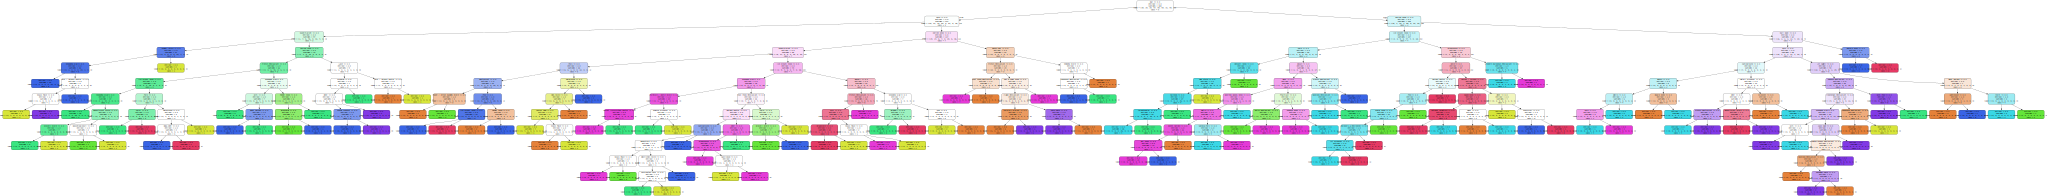

In [256]:
import graphviz 
dot_data = tree.export_graphviz(
    clf, 
    feature_names=X.columns.values,
    class_names=list(map(str,range(max(Y)+1))),
    filled=True, rounded=True, precision=0,
    out_file=None) 
graph = graphviz.Source(dot_data, format='svg')
graph.render(filename='city_decision')
graph

# Chromopleth map

We obtained a Shapefile of Dutch city-border from [Imergis](http://www.imergis.nl/asp/47.asp), then converted it to geoJSON using [Mapshaper](https://mapshaper.org/). We will read it and see which city names it contains.

In [270]:
import json
geojson_data = open('gemeenten.json').read()
geojson = json.loads(geojson_data)

In [274]:
cities = []
for i in geojson['features']:
    cities.append(i['properties']['gemeentena'])
len(cities)

380

There are 380 cities in the list. This agrees with all cities in the Netherlands except Caribbean Netherlands. So let's drop those.

In [281]:
import difflib

In [286]:
df_cities3['City'].map(lambda x: difflib.get_close_matches(x, cities))

0                             ['s-Hertogenbosch]
1                              [Alkmaar, Almere]
2                                   [Amersfoort]
3                            [Arnhem, Gorinchem]
4                       [Assen, Asten, Meerssen]
5                         [Baarn, Haaren, Laren]
6                   [Blaricum, Castricum, Marum]
7                          [Breda, Buren, Borne]
8                                       [Bunnik]
9                                             []
10         [Dordrecht, Woensdrecht, Barendrecht]
11                          [Goeree-Overflakkee]
12                       [Goirle, Borsele, Goes]
13                                [Gooise Meren]
14              [Haarlemmerliede en Spaarnwoude]
15                           [Horst aan de Maas]
16                             [Kampen, Kapelle]
17                  [Leeuwarden, Leusden, Laren]
18                       [Leidschendam-Voorburg]
19                          [Lelystad, Westland]
20                  